In [1]:
#Project 1  Vincent is still a monkey
import pandas as pd
# import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

/opt/homebrew/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Question 1: Reading and formatting dataset

In [2]:
#1.1
df = pd.read_csv("GermanCredit.txt", sep ="\s+", header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,1
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,2
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,1
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,1
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4,12,2,17,1,4,2,4,1,31,...,0,0,1,0,0,1,0,1,0,1
996,1,30,2,39,1,3,1,4,2,40,...,0,1,1,0,0,1,0,0,0,1
997,4,12,2,8,1,5,3,4,3,38,...,0,0,1,0,0,1,0,0,1,1
998,1,45,2,18,1,3,3,4,4,23,...,0,0,1,0,0,0,0,0,1,2


In [3]:
#1.2
df[24] = df[24] - 1
df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,0
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,1
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,0
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,0
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4,12,2,17,1,4,2,4,1,31,...,0,0,1,0,0,1,0,1,0,0
996,1,30,2,39,1,3,1,4,2,40,...,0,1,1,0,0,1,0,0,0,0
997,4,12,2,8,1,5,3,4,3,38,...,0,0,1,0,0,1,0,0,1,0
998,1,45,2,18,1,3,3,4,4,23,...,0,0,1,0,0,0,0,0,1,1


In [4]:
M = 800
d = 24
length = df.shape[0]
y_train = df.loc[:M-1, d]
y_test = df.loc[M:, d]

x_train = df.loc[:M-1, :d-1]
x_test = df.loc[M:, :d-1]

In [5]:
#1.3
from sklearn.preprocessing import StandardScaler

In [6]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape

(800, 24)

In [7]:
x_train.shape

(800, 24)

In [8]:
#1.4
ones_train = jnp.ones((M, 1))
ones_test = jnp.ones((length-M, 1))
x_train = jnp.concatenate((ones_train, x_train), axis=1)
x_train.shape

(800, 25)

In [9]:
x_test = jnp.concatenate((ones_test, x_test), axis=1)
x_test.shape

(200, 25)

In [10]:
jnp.mean(x_train, axis=0), jnp.std(x_train, axis=0)

(DeviceArray([ 1.00000000e+00,  5.36441780e-09,  3.57627861e-09,
               1.19209287e-09,  2.38418574e-09, -7.15255721e-09,
              -3.93390636e-08, -2.68220890e-09,  1.07288356e-08,
              -3.06963912e-08, -1.07288356e-08,  2.02655794e-08,
              -3.75509259e-08, -2.14576712e-08, -5.12599918e-08,
               3.87430177e-08,  1.47521488e-08,  2.38418574e-09,
               3.36766242e-08,  1.78813924e-08,  3.72529030e-09,
               0.00000000e+00,  3.57627861e-09,  2.68220894e-08,
              -1.40070915e-08], dtype=float32),
 DeviceArray([0.        , 1.0000001 , 1.        , 0.9999999 , 1.        ,
              1.        , 1.        , 1.        , 1.        , 1.        ,
              0.99999994, 1.0000001 , 0.9999999 , 1.0000001 , 0.99999994,
              0.99999994, 1.0000002 , 0.9999997 , 0.99999994, 1.        ,
              0.99999994, 1.        , 1.0000001 , 1.        , 1.0000001 ],            dtype=float32))

# Question 2: Model specification

In [11]:
#2.1
import jax.numpy as jnp
from jax import grad, jit, vmap


In [12]:
#2.2

In [13]:
#2.3

In [108]:
#2.4

# def loglikelihood(beta):
#     x_beta = np.matmul(x_train, beta)
#     output = np.sum(y_train * x_beta - np.log(1 + np.exp(x_beta)))
#     return output

@jit
def loglikelihood_jax(beta):
    x_beta = jnp.matmul(x_train, beta)
    output = jnp.sum(y_train * x_beta - jnp.log(1 + jnp.exp(x_beta)))
    return output

jit_likelihood_jax = jit(loglikelihood_jax)


In [109]:
#2.5

In [110]:
#2.6
from jax import grad

gradloglikelihood = jit(grad(loglikelihood_jax))

In [51]:
#2.7
from jax.scipy.stats.multivariate_normal import logpdf as jlogpdf

DIM = 25
constant = jnp.pi**2 * M/(3*DIM)
Sigma = constant * jnp.linalg.inv(jnp.matmul(x_train.T, x_train))

@jit
def logprior(beta):
    return jlogpdf(beta, mean = jnp.zeros(DIM), cov = Sigma)

In [52]:
#2.8
gradlogprior = jit(grad(logprior))

In [53]:
# 2.9 
def logdensity(beta):
    return logprior(beta) + loglikelihood(beta)


In [111]:
# 2.10 
def gradlogdensity(beta):
    return gradlogprior(beta) + gradloglikelihood(beta)

# Section 3

In [55]:
# Q1: independent Metropolis-Hastings
from scipy.stats import multivariate_normal
def sample_prior():
    return multivariate_normal.rvs(mean = np.zeros(DIM), cov=Sigma)

beta = sample_prior()
N = 10000
store_beta = np.zeros((N,DIM))
n_accept = 0


/opt/homebrew/lib/python3.9/site-packages/scipy/stats/_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


In [56]:
#run the loop
for n in range(N):
    #sample a proposed state
    proposed_state = sample_prior()
    
    #evaluate posterior density
    logdensity_proposed = logdensity(proposed_state)
    logdensity_current = logdensity(beta)
    
    #evaluate prior density
    logprior_proposed = logprior(proposed_state)
    logprior_current = logprior(beta)
    
    #log acceptance prob
    logacceptprob = logdensity_proposed + logprior_current - logdensity_current - logprior_proposed
    
    #accept tor reject
    uniform = np.random.rand(1) # sample a uniform on [0,1]
    if np.log(uniform) < logacceptprob:
        beta = proposed_state.copy() #accept
        n_accept += 1
    
    store_beta[n,:] = beta

In [57]:
print("Acceptance rate: ", n_accept/N )

Acceptance rate:  0.0006


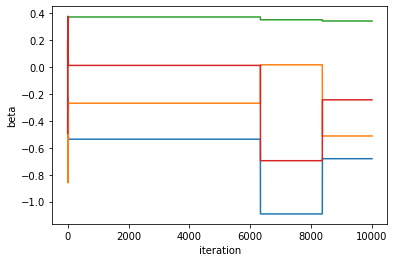

In [58]:
iteration = np.arange(1,N+1)
plt.figure()
plt.plot(iteration, store_beta[:,0])
plt.plot(iteration, store_beta[:,1])
plt.plot(iteration, store_beta[:,2])
plt.plot(iteration, store_beta[:,3])
plt.xlabel('iteration')
plt.ylabel('beta')
plt.show()

In [86]:
#3.2
s = 0.02
SIG = jnp.eye(DIM) * s**2
rng = jax.random.PRNGKey(0)
n_accept = 0
store_beta = np.zeros((N,DIM))
beta = sample_prior()

for n in range(N):
#     epsilon = jax.random.multivariate_normal(key=rng, mean= jnp.zeros(DIM), cov=SIG)  
    epsilon = np.random.multivariate_normal(mean= jnp.zeros(DIM), cov=SIG)  

    proposed_state = beta + epsilon
    
    pi_y = logdensity(proposed_state)
    pi_x = logdensity(beta)
    
    logacceptprob = float(pi_y - pi_x)
    
    #accept tor reject
    uniform = np.random.rand(1) # sample a uniform on [0,1]
    if np.log(uniform) < logacceptprob:
        beta = proposed_state.copy() #accept
        n_accept += 1
    store_beta[n,:] = beta
    

In [87]:
n_accept/N

0.5763

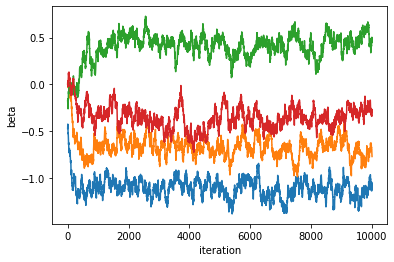

In [88]:
iteration = np.arange(1,N+1)
plt.figure()
plt.plot(iteration, store_beta[:,0])
plt.plot(iteration, store_beta[:,1])
plt.plot(iteration, store_beta[:,2])
plt.plot(iteration, store_beta[:,3])
plt.xlabel('iteration')
plt.ylabel('beta')
plt.show()

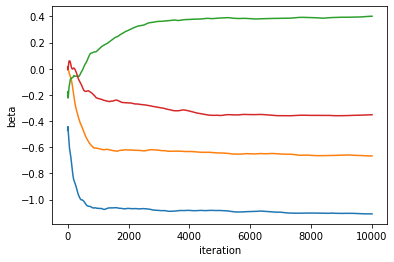

In [89]:
iteration = np.arange(1,N+1)
plt.figure()
plt.plot(iteration, np.cumsum(store_beta[:,0])/iteration)
plt.plot(iteration, np.cumsum(store_beta[:,1])/iteration)
plt.plot(iteration, np.cumsum(store_beta[:,2])/iteration)
plt.plot(iteration, np.cumsum(store_beta[:,3])/iteration)
plt.xlabel('iteration')
plt.ylabel('beta')
plt.show()

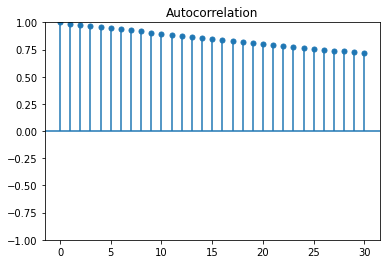

<Figure size 432x288 with 0 Axes>

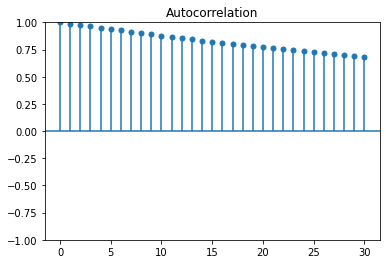

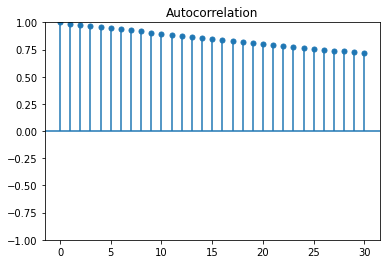

In [90]:
# auto-correlation function
from statsmodels.graphics.tsaplots import plot_acf

plt.figure()
plot_acf(store_beta[2000:,0], lags = 30, alpha = None)
plot_acf(store_beta[2000:,1], lags = 30, alpha = None)

In [114]:
# 3.3
import scipy
s = 0.08
SIG = jnp.eye(DIM) * s**2
rng = jax.random.PRNGKey(0)
n_accept = 0
store_beta = np.zeros((N,DIM))
beta = sample_prior()

for n in range(N):
#     epsilon = jax.random.multivariate_normal(key=rng, mean= jnp.zeros(DIM), cov=SIG)    
    epsilon = np.random.multivariate_normal(mean= jnp.zeros(DIM), cov=SIG)    
    
    proposed_state = beta + s**2 /2 * gradlogdensity(beta) + epsilon
    
    pi_y = logdensity(proposed_state)
    pi_x = logdensity(beta)
    q_y = jlogpdf(proposed_state, mean = beta + s**2 /2 \
                                                 * gradlogdensity(beta) , cov=SIG)
    q_x = jlogpdf(beta , mean = proposed_state + s**2 /2 \
                                                 * gradlogdensity(proposed_state) , cov=SIG)
    
    
    
    logacceptprob = float(pi_y + q_x - pi_x - q_y)
    
    #accept tor reject
    uniform = np.random.rand(1) # sample a uniform on [0,1]
    if np.log(uniform) < logacceptprob:
        beta = proposed_state.copy() #accept
        n_accept += 1
    store_beta[n,:] = beta
    

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(float32[800])>with<JVPTrace(level=2/2)> with
  primal = Traced<ShapedArray(float32[800])>with<DynamicJaxprTrace(level=0/2)>
  tangent = Traced<ShapedArray(float32[800])>with<JaxprTrace(level=1/2)> with
    pval = (ShapedArray(float32[800]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x16a932630>, in_tracers=(Traced<ShapedArray(float32[800]):JaxprTrace(level=1/2)>, Traced<ShapedArray(float32[800]):JaxprTrace(level=1/2)>), out_tracer_refs=[<weakref at 0x16a705c70; to 'JaxprTracer' at 0x16a705db0>], out_avals=[ShapedArray(float32[800])], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(fn)', 'donated_invars': (False, False), 'inline': True, 'keep_unused': False, 'call_jaxpr': { [34m[22m[1mlambda [39m[22m[22m; a[35m:f32[800][39m b[35m:f32[800][39m. [34m[22m[1mlet[39m[22m[22m c[35m:f32[800][39m = mul b a [34m[22m[1min [39m[22m[22m(c,) }}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x16a6bdcb0>, name_stack=NameStack(stack=())))
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [99]:
n_accept/N

0.04

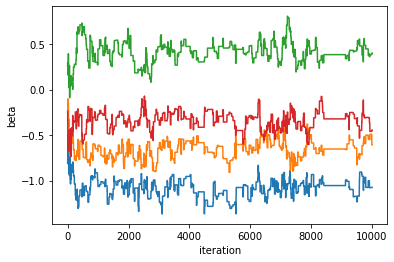

In [102]:
iteration = np.arange(1,N+1)
plt.figure()
plt.plot(iteration, store_beta[:,0])
plt.plot(iteration, store_beta[:,1])
plt.plot(iteration, store_beta[:,2])
plt.plot(iteration, store_beta[:,3])
plt.xlabel('iteration')
plt.ylabel('beta')
plt.show()

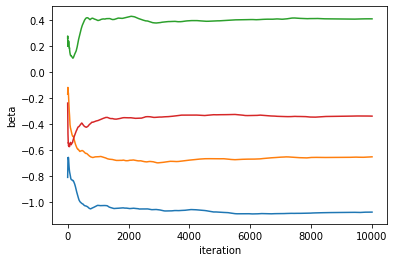

In [103]:
iteration = np.arange(1,N+1)
plt.figure()
plt.plot(iteration, np.cumsum(store_beta[:,0])/iteration)
plt.plot(iteration, np.cumsum(store_beta[:,1])/iteration)
plt.plot(iteration, np.cumsum(store_beta[:,2])/iteration)
plt.plot(iteration, np.cumsum(store_beta[:,3])/iteration)
plt.xlabel('iteration')
plt.ylabel('beta')
plt.show()

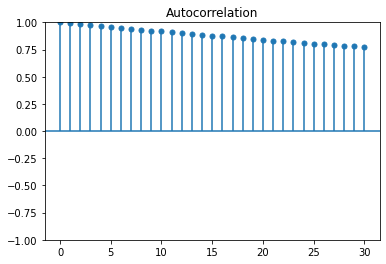

<Figure size 432x288 with 0 Axes>

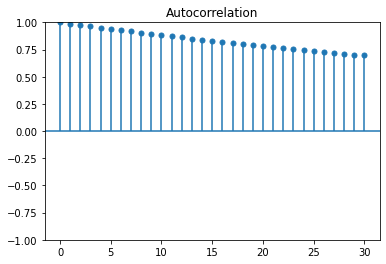

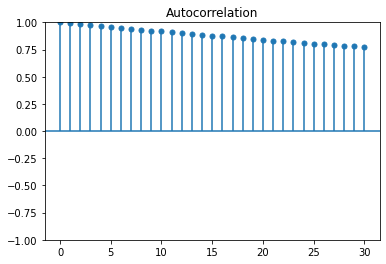

In [105]:
# auto-correlation function
from statsmodels.graphics.tsaplots import plot_acf

plt.figure()
plot_acf(store_beta[2000:,0], lags = 30, alpha = None)
plot_acf(store_beta[2000:,1], lags = 30, alpha = None)

In [ ]:
#3.4
import numpy as np

def hamiltonian_dynamics(current_state, current_velocity, stepsize, num_steps, gradlogdensity):
    x = current_state
    v = current_velocity
    """Simulate Hamiltonian dynamics."""    
    v = v + stepsize * np.array(gradlogdensity(x)) / 2
    for step in range(num_steps): 
        x = x + stepsize * v
  if step != (num_steps-1):
    v = v + stepsize * np.array(gradlogdensity(x))
    v = v + stepsize * np.array(gradlogdensity(x)) / 2    
    return (x, v)